In [1]:
# %%
import torch
from torch import nn
import numpy as np

from pit.dynamics.dynamic_bicycle import DynamicBicycle
from pit.parameters import NormalParameterGroup, CovariantNormalParameterGroup
from pit.integration import Euler, RK4

import matplotlib.pyplot as plt
import json

DEVICE = 'cpu' # "cuda" if torch.cuda.is_available() else "cpu"

print(DEVICE)

# input parameters
map_name = 'SaoPaulo'  # Nuerburgring,  SaoPaulo
lap_number = 2  # 1 - faster, 2 - slower
friction = '1-1'  # '1-1' - mu_x = 1.1, '0-7' - mu_x = 0.7

# visualization
with open('dataset_%s_%s_lap%s.json' % (friction, map_name, lap_number), 'r') as f:
    data = json.load(f)

cpu


In [2]:
# %%
timestep = 0.01
assert(data['time'][1] - data['time'][0] - timestep < 0.001)
x = torch.tensor(data['x'])
y = torch.tensor(data['y'])
yaw = torch.tensor(data['yaw'])
vx = torch.tensor(data['vx'])
vy = torch.tensor(data['vy'])
yaw_rate = torch.tensor(data['yaw_rate'])
steer_angle = torch.tensor(data['steer_angle'])
drive_force = torch.tensor(data['drive_force'])
steer_speed = torch.tensor(data['steer_speed'])

In [3]:
# %%
initial_state = torch.tensor([x[0],y[0],yaw[0],vx[0],vy[0],yaw_rate[0],steer_angle[0]]).to(DEVICE)
control_inputs = torch.vstack([drive_force, steer_speed]).T
control_inputs = control_inputs.contiguous().to(DEVICE)
output_states = torch.vstack([x, y, yaw, vx, vy, yaw_rate, steer_angle]).T
target_states = output_states[1:]
target_states = target_states.contiguous().to(DEVICE)

print(f"Inputs size: {control_inputs.shape} | States size: {target_states.shape}")

Inputs size: torch.Size([22486, 2]) | States size: torch.Size([22486, 7])


In [4]:
# %%
STEP_SIZE=10
TICKS_IN_STEP=50
state_dims = initial_state.shape[0]
input_dims = control_inputs.shape[-1]
total_steps = (control_inputs.shape[0]-TICKS_IN_STEP-1)//STEP_SIZE

batched_initial_states = torch.zeros((total_steps, state_dims), device=DEVICE)
batched_control_inputs = torch.zeros((total_steps, TICKS_IN_STEP, input_dims), device=DEVICE)
batched_target_states = torch.zeros((total_steps, TICKS_IN_STEP, state_dims), device=DEVICE)

for step in range(total_steps):
    batched_initial_states[step] = output_states[step*STEP_SIZE]
    batched_control_inputs[step] = control_inputs[step*STEP_SIZE:(step*STEP_SIZE)+TICKS_IN_STEP]
    batched_target_states[step] = output_states[(step*STEP_SIZE)+1:(step*STEP_SIZE)+TICKS_IN_STEP+1]

print(f"Batched Inputs size: {batched_control_inputs.shape} | Batched States size: {batched_target_states.shape}")

Batched Inputs size: torch.Size([2243, 50, 2]) | Batched States size: torch.Size([2243, 50, 7])


In [5]:
# %%
dataset = torch.utils.data.TensorDataset(batched_initial_states, batched_control_inputs, batched_target_states)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [6]:
# %%
params = {
    # axes distances
    'lf': 0.88392,  # distance from spring mass center of gravity to front axle [m]  LENA
    'lr': 1.50876,  # distance from spring mass center of gravity to rear axle [m]  LENB

    # moments of inertia of sprung mass
    # masses
    'Iz': 1538.853371,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
    'mass': 1225.887,  # vehicle mass [kg]  MASS

    # Pacejka tire force parameters
    'Df': 3709.08227,  # [rad/m]  DF
    'Cf': 1.3507,
    'Bf': 16.2216,
    'Dr': 3709.08227,  # [rad/m]  DR
    'Cr': 1.3507,
    'Br': 16.2216,
    'Cm': 0.3777,
    'Cr0': 2.1469,
    'Cr2': 0.0,
}
# params.update({
#     "lf" : 0.8839200139045715,
#     "lr" : 1.5087599754333496,
#     "Iz" : 1771.53857421875,
#     "mass" : 701.0275268554688,
#     "Df" : 4041.601318359375,
#     "Cf" : 1.4304611682891846,
#     "Bf" : 18.741268157958984,
#     "Dr" : 3652.13427734375,
#     "Cr" : 0.7047927379608154,
#     "Br" : 27.620542526245117,
#     "Cm" : 0.5324415564537048,
#     "Cr0" : 10.995059967041016,
#     "Cr2" : -0.03063417412340641,
# })
dynamics = DynamicBicycle(**params)
param_group = NormalParameterGroup(dynamics.parameter_list, params)
#dynamics = torch.load("fitted_model.pt")
# <---- FIX PHYSICAL PARAMS     ---->
# dynamics.lf.requires_grad = False
# dynamics.lr.requires_grad = False
# dynamics.mass.requires_grad = False
# dynamics.Iz.requires_grad = False
# dynamics.Df.requires_grad = True
# dynamics.Cf.requires_grad = True
# dynamics.Bf.requires_grad = True
# dynamics.Dr.requires_grad = True
# dynamics.Cr.requires_grad = True
# dynamics.Br.requires_grad = True
# dynamics.Cm.requires_grad = True
# dynamics.Cr0.requires_grad = True
# dynamics.Cr2.requires_grad = True
# <----                         ---->
# euler_integrator = Euler(dynamics, timestep=timestep)
# euler_integrator.to(DEVICE)
rk4_integrator = RK4(dynamics=dynamics, parameters=param_group, timestep=timestep)
rk4_integrator.to(DEVICE)


RK4(
  (dynamics): DynamicBicycle()
  (model_params): NormalParameterGroup(
    (positive): Positive()
  )
)

In [7]:
for param in param_group.parameters():
    print(param)
print(param_group.scale)

Parameter containing:
tensor([8.8392e-01, 1.5088e+00, 1.5389e+03, 1.2259e+03, 3.7091e+03, 1.3507e+00,
        1.6222e+01, 3.7091e+03, 1.3507e+00, 1.6222e+01, 3.7770e-01, 2.1469e+00,
        0.0000e+00], requires_grad=True)
Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       requires_grad=True)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<AddBackward0>)


In [8]:
with torch.no_grad():
    rk4_integrator.eval()
    initial_guess_output_states = rk4_integrator(initial_state, control_inputs)


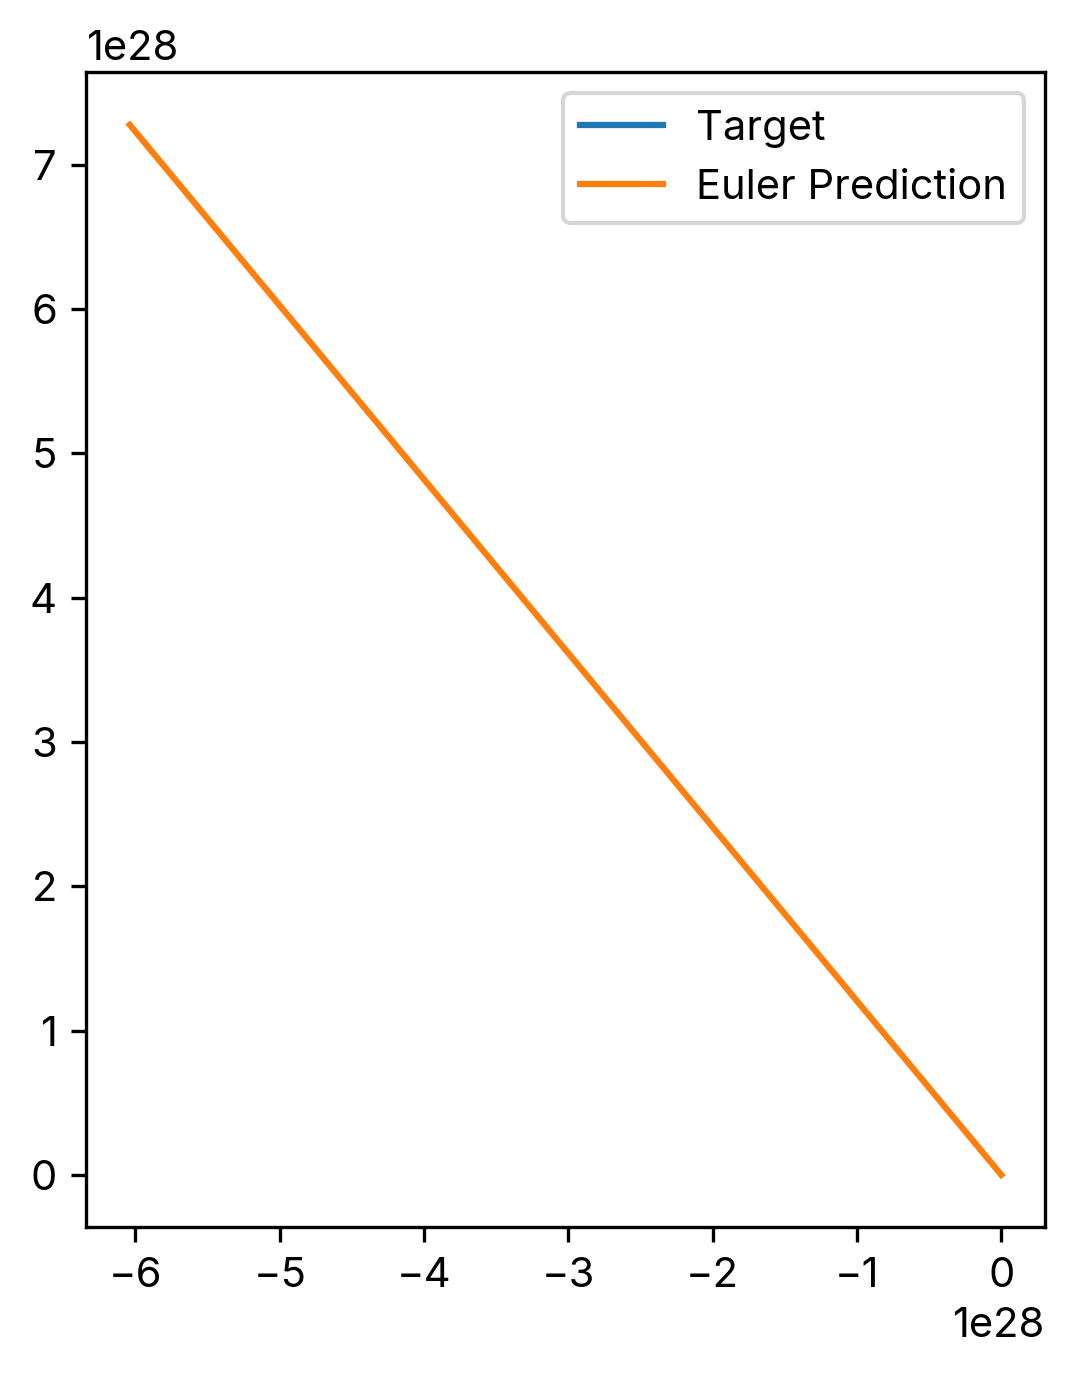

In [ ]:
# %%
fig, ax = plt.subplots(1, 1, figsize=(5,5))
LEN=20000
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
ax.plot(initial_guess_output_states[:LEN, 0].detach().cpu().numpy(), initial_guess_output_states[:LEN, 1].detach().cpu().numpy(), label="Euler Prediction")
#ax.plot(rk4_output_states[:LEN, 0].detach().cpu().numpy(), rk4_output_states[:LEN, 1].detach().cpu().numpy(), label="RK4 Prediction")
ax.set_aspect(1.0)
ax.legend()

In [ ]:
# %%
from tqdm.auto import tqdm
EPOCHS = 500
integrator: RK4 = rk4_integrator
optimizer = torch.optim.SGD(integrator.parameters(), lr=1, momentum=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.7)
 
# with torch.no_grad():
#     output_states = integrator(initial_state, control_inputs)
#     val_loss = torch.nn.functional.l1_loss(output_states, target_states)
# print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

losses = list()
lrs = list()

for i in tqdm(range(EPOCHS)):
    for initial, inputs, targets in dataloader:
        integrator.train()
        optimizer.zero_grad()
        output_states = integrator(initial, inputs)
        loss = torch.nn.functional.l1_loss(output_states, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(integrator.parameters(), 1.0)
        optimizer.step()
    #for name, param in integrator.named_parameters():
    #    if param.requires_grad:
    #        print(name, param.data, param.grad)
    if i%20 == 0 and False:
        with torch.no_grad():
            output_states = integrator(initial_state, control_inputs)
            val_loss = torch.nn.functional.l1_loss(output_states, target_states)
        fig, ax = plt.subplots(1, 1, figsize=(10,10))
        LEN=20000
        ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
        ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
        ax.set_aspect(1.0)
        ax.legend()
        plt.show()
        print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    if i%20 == 0 and False:
        # Plot the covariance matrix of the parameters, and then the means below them, each as an imshow
        fig, ax = plt.subplots(2, 1, figsize=(3,3), sharex=True)
        cov = param_group.covariance
        mean = param_group.loc
        ax[0].imshow(cov.numpy(force=True))
        ax[1].imshow(mean.numpy(force=True).reshape(1, -1))
        plt.colorbar(ax[0].imshow(cov.numpy(force=True)))
        plt.colorbar(ax[1].imshow(mean.numpy(force=True).reshape(1, -1)))
        plt.show()
    if i%20 == 0 and False:
        # Plot the mean and variance of each parameter as normal distributions
        tqdm.write("Mean: " + str(param_group.loc))
        tqdm.write("Scale: " + str(param_group.scale))
        # fig, ax = plt.subplots(2, 1, figsize=(10,10), sharex=True)
        # mean = param_group.loc.numpy(force=True)
        # std = torch.diag(param_group.scale).numpy(force=True)
        # for i in range(len(mean)):
        #     x = np.linspace(mean[i]-3*std[i], mean[i]+3*std[i], 100)
        #     y = np.exp(-0.5*((x-mean[i])/std[i])**2)/(std[i]*np.sqrt(2*np.pi))
        #     ax[0].plot(x, y)
        #     ax[0].set_title("Mean")
        #     ax[1].plot(x, y)
        #     ax[1].set_title("Standard Deviation")
        plt.show()
    with torch.no_grad():
        integrator.eval()
        output_states = integrator(batched_initial_states,batched_control_inputs)
        val_loss = torch.nn.functional.l1_loss(output_states, batched_target_states)
        losses.append(val_loss.item())
    # tqdm.write(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step(val_loss)


/root/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'rk4_integrator' is not defined

In [ ]:
for param in param_group.parameters():
    print(param)

Parameter containing:
tensor([ 9.6031e-01,  1.3391e+00,  1.5389e+03,  1.2259e+03,  3.7091e+03,
         3.6850e+00,  1.6420e+01,  3.7091e+03,  3.1886e+00,  1.6274e+01,
         9.6266e-01,  2.1475e+00, -1.0014e-03], requires_grad=True)
Parameter containing:
tensor([-2.6678, -3.4712,  1.0001,  0.9998,  1.0000, -1.3367,  0.6429,  1.0000,
        -1.4310,  0.6818, -3.1229,  0.9972, -2.8116], requires_grad=True)


In [ ]:
print(f"Mean: {param_group.loc}")
print(f"Scale: {param_group.scale}")

Mean: Parameter containing:
tensor([ 9.6031e-01,  1.3391e+00,  1.5389e+03,  1.2259e+03,  3.7091e+03,
         3.6850e+00,  1.6420e+01,  3.7091e+03,  3.1886e+00,  1.6274e+01,
         9.6266e-01,  2.1475e+00, -1.0014e-03], requires_grad=True)
Scale: tensor([0.0671, 0.0306, 1.3133, 1.3131, 1.3133, 0.2333, 1.0654, 1.3133, 0.2144,
        1.0910, 0.0431, 1.3112, 0.0584], grad_fn=<SoftplusBackward0>)


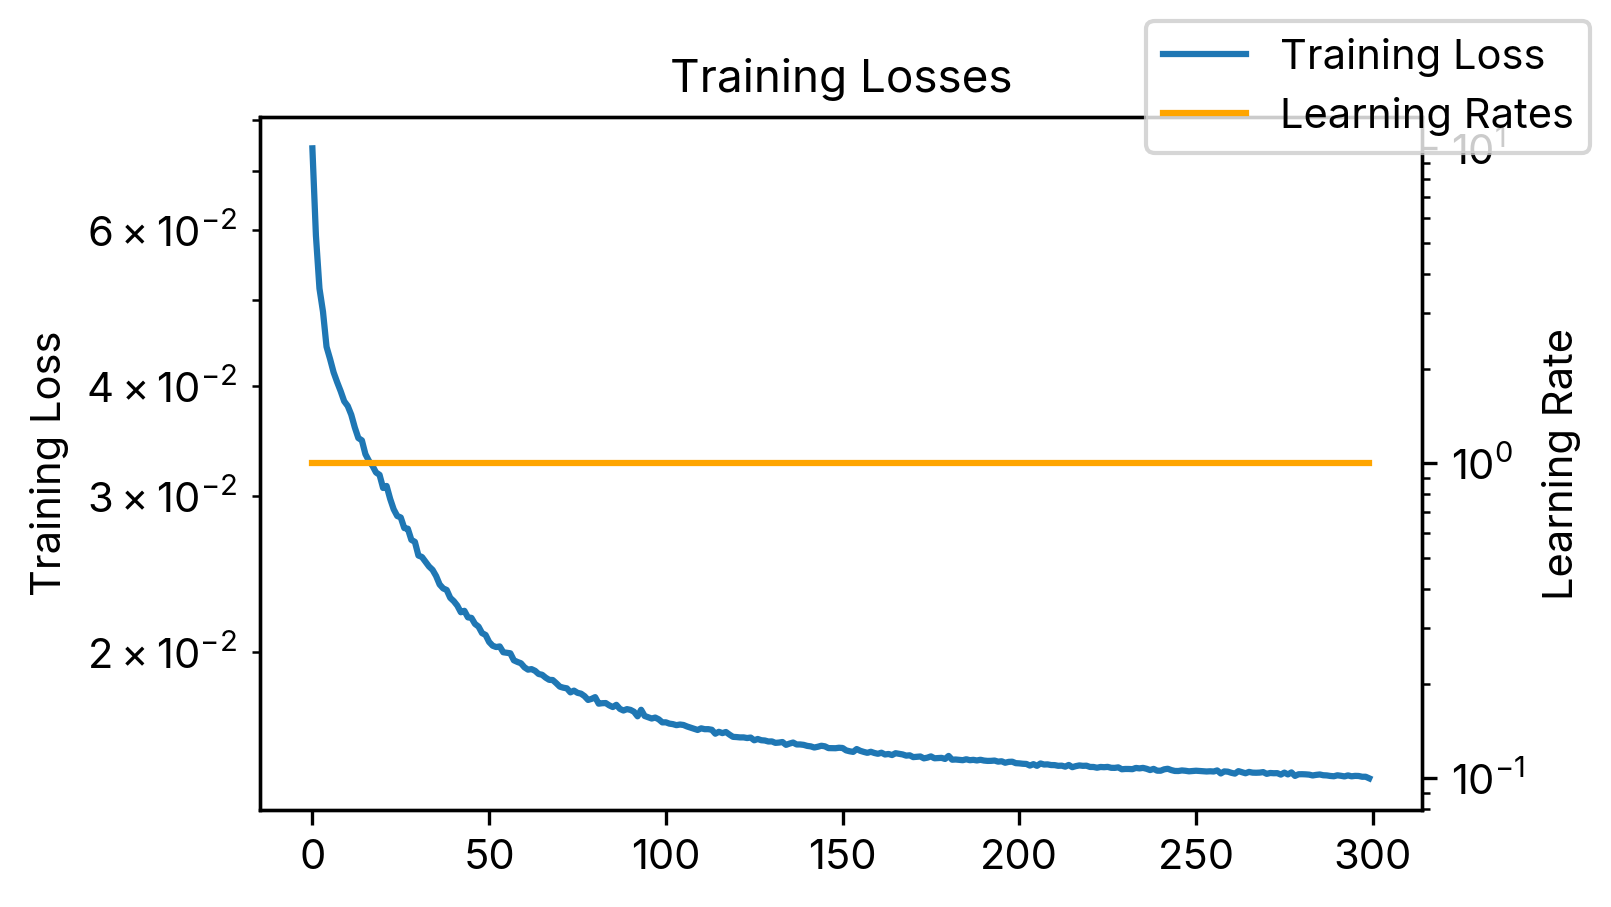

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(losses, label='Training Loss')
ax.set_ylabel("Training Loss")
ax.set_yscale('log')
secax = ax.twinx()
secax.set_ylabel("Learning Rate")
secax.plot(lrs, label="Learning Rates", color='orange')
secax.set_yscale('log')
ax.set_title("Training Losses")
fig.legend()
plt.show()

In [ ]:
# %%
with torch.no_grad():
    integrator.eval()
    output_states = integrator(initial_state, control_inputs)
    val_loss = torch.nn.functional.l1_loss(output_states, target_states)

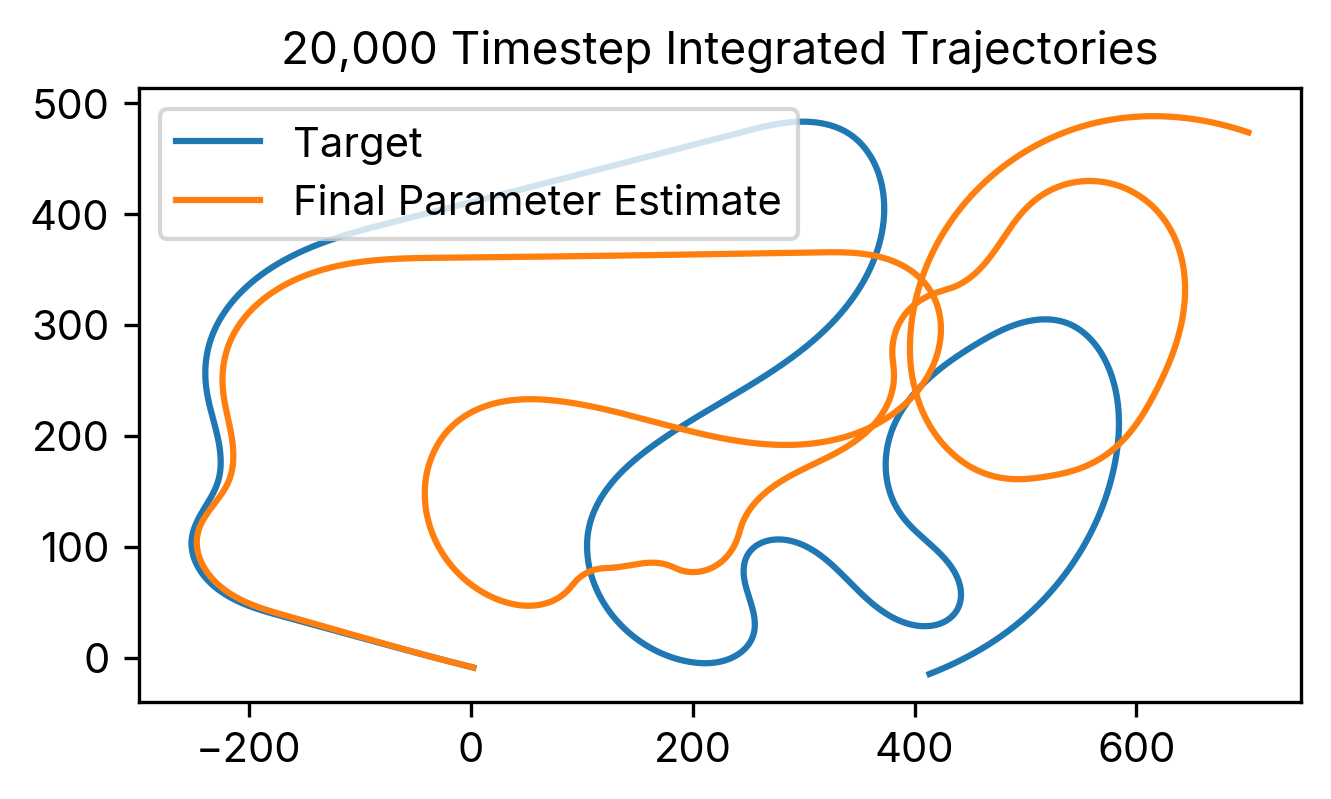

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
LEN=20000
ax.plot(target_states[:LEN, 1].cpu().numpy(), target_states[:LEN, 0].cpu().numpy(), label="Target")
ax.plot(output_states[:LEN, 1].detach().cpu().numpy(), output_states[:LEN, 0].detach().cpu().numpy(), label="Final Parameter Estimate")
# ax.plot(initial_guess_output_states[:LEN, 1].detach().cpu().numpy(), initial_guess_output_states[:LEN, 0].detach().cpu().numpy(), label="Initial Parameter Estimate")
ax.set_aspect(1.0)
ax.legend()
ax.set_title("20,000 Timestep Integrated Trajectories")
plt.savefig("integrated_traj.pdf", bbox_inches='tight')
plt.show()

In [ ]:
torch.norm(output_states[:,:2] - target_states[:,:2])/output_states.shape[0]

tensor(2.1094)

In [ ]:
output_states.shape

torch.Size([22486, 7])

In [ ]:
print("{")
for key in dynamics.state_dict().keys():
    print(f"\t\"{key}\" : {dynamics.state_dict()[key]},")
print("}")

{
}


In [ ]:
rk4_integrator.model_params.distribution.covariance_matrix

AttributeError: 'NormalParameterGroup' object has no attribute 'distribution'